In [2]:
import pandas as pd

teams = pd.read_csv("../data/Teams.csv")

print(teams.shape)
print(teams.columns.tolist())
teams.head()


(3614, 48)
['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']


,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,24.0,0.834,Boston Red Stockings,South End Grounds I,NaN,103.0,98.0,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,16.0,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104.0,102.0,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,15.0,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96.0,100.0,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,8.0,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101.0,107.0,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,14.0,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90.0,88.0,NYU,NY2,NY2


In [3]:
features = ["W", "R", "RA", "HR", "BB", "SO"]

df = teams[teams["yearID"] >= 2000][
    ["yearID", "teamID"] + features
].dropna().copy()

df["RunDiff"] = df["R"] - df["RA"]

corr = df[["W", "R", "RA", "HR", "BB", "SO", "RunDiff"]].corr(numeric_only=True)["W"]
corr.sort_values(ascending=False)


W          1.000000
R          0.776961
RunDiff    0.725616
BB         0.693232
HR         0.586804
SO         0.312037
RA         0.081112
Name: W, dtype: float64

## Model A: Runs scored & allowed

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

X_a = df[["R", "RA", "HR", "BB", "SO"]]
y = df["W"]

X_train, X_test, y_train, y_test = train_test_split(
    X_a, y, test_size=0.2, random_state=42
)

model_a = LinearRegression()
model_a.fit(X_train, y_train)

pred_a = model_a.predict(X_test)

print("Model A MAE:", mean_absolute_error(y_test, pred_a))
print("Model A R²:", r2_score(y_test, pred_a))


Model A MAE: 4.861111549261402
Model A R²: 0.851682356240807


## Model B: Run differential only

In [5]:
X_b = df[["RunDiff"]]

X_train, X_test, y_train, y_test = train_test_split(
    X_b, y, test_size=0.2, random_state=42
)

model_b = LinearRegression()
model_b.fit(X_train, y_train)

pred_b = model_b.predict(X_test)

print("Model B MAE:", mean_absolute_error(y_test, pred_b))
print("Model B R²:", r2_score(y_test, pred_b))


Model B MAE: 5.812399989753811
Model B R²: 0.45391602477257686


In [6]:
coef_a = pd.Series(model_a.coef_, index=X_a.columns).sort_values(key=abs, ascending=False)
coef_a


R     0.152005
HR   -0.081571
RA   -0.080707
SO    0.020485
BB    0.005186
dtype: float64

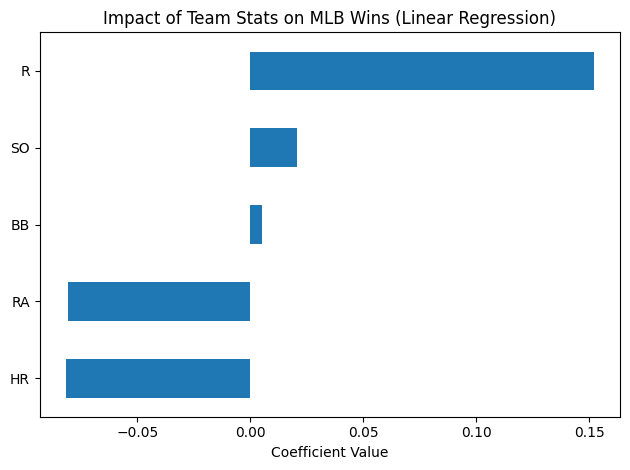

In [7]:
import matplotlib.pyplot as plt

coef_a.sort_values().plot(kind="barh")
plt.title("Impact of Team Stats on MLB Wins (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.savefig("../visuals/model_coefficients.png", dpi=200)
plt.show()


In [8]:
coef_a.to_csv("../data/model_coefficients.csv")
